векторное умножение
CPU считает корректно ( векторное умножение )
GPU считает корректно ( векторное умножение )
Выполнился эксперимент для матрицы размерности 100 - векторное умножение (0.015598c)
Выполнился эксперимент для матрицы размерности 128 - векторное умножение (0.025456c)
Выполнился эксперимент для матрицы размерности 256 - векторное умножение (0.117020c)
Выполнился эксперимент для матрицы размерности 512 - векторное умножение (0.845953c)
Выполнился эксперимент для матрицы размерности 1024 - векторное умножение (5.164465c)
Выполнился эксперимент для матрицы размерности 2048 - векторное умножение (55.241183c)
|						векторное умножение						|
|Размерность	|100.000000	|128.000000	|256.000000	|512.000000	|1024.000000	|2048.000000	|
|CPU время	|0.015598	|0.025456	|0.117020	|0.845953	|5.164465	|55.241183	|
|GPU время	|0.000358	|0.000280	|0.000277	|0.000358	|0.000401	|0.000430	|
|Ускорение	|43.614000	|90.790816	|423.118103	|2360.733866	|12885.982748	|128364.717452	|


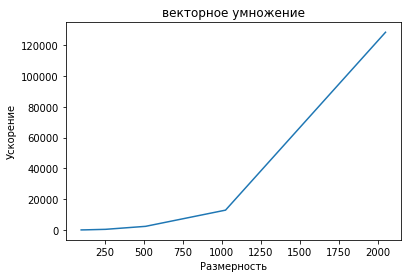

поэлементное умножение
CPU считает корректно ( поэлементное умножение )
GPU считает корректно ( поэлементное умножение )
Выполнился эксперимент для матрицы размерности 100 - поэлементное умножение (0.780115c)
Выполнился эксперимент для матрицы размерности 128 - поэлементное умножение (1.598936c)
Выполнился эксперимент для матрицы размерности 256 - поэлементное умножение (12.496746c)
Выполнился эксперимент для матрицы размерности 512 - поэлементное умножение (104.414774c)
Выполнился эксперимент для матрицы размерности 1024 - поэлементное умножение (850.494305c)
Выполнился эксперимент для матрицы размерности 2048 - поэлементное умножение (6789.736923c)
|						поэлементное умножение						|
|Размерность	|100.000000	|128.000000	|256.000000	|512.000000	|1024.000000	|2048.000000	|
|CPU время	|0.780115	|1.598936	|12.496746	|104.414774	|850.494305	|6789.736923	|
|GPU время	|0.000320	|0.000374	|0.000380	|0.000448	|0.000460	|0.000439	|
|Ускорение	|2434.553571	|4279.785578	|32882.780427	|232950.69

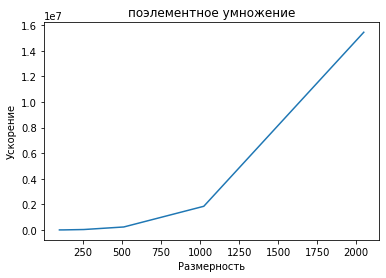

In [1]:
import numpy as np
from numba import cuda
from time import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

def create_matrix(n):
  a = np.random.randint(0, 10, (n, n))
  b = np.random.randint(0, 10, (n, n))
  c = np.zeros((n, n))
  return a, b, c

def mul_cpu_element(a, b):
  n=len(a)
  c = np.zeros((n,n))
  start = time()
  for i in range(n):
    for j in range(n):
      for k in range(n):
        c[i, j] += a[i,k] * b[k,j]
  return c, time()-start
    
def mul_cpu_vector(a, b):
  n=len(a)
  c = np.zeros((n,n))
  start = time()
  for i in range(n):
    for j in range(n):
      c[i, j] = np.dot(a[i,:], b[:,j])
  return c, time()-start

def mul_cpu_matrix(a, b):
  start = time()
  c = np.dot(a, b)
  return c, time() - start

@cuda.jit
def gpu_mul_operation(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
      tmp = 0
      for k in range(a.shape[1]):
        tmp += a[i, k] * b[k, j]
      c[i, j] = tmp

@cuda.jit
def gpu_mul_operation(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
      tmp = 0
      for k in range(a.shape[1]):
        tmp += a[i, k] * b[k, j]
      c[i, j] = tmp

@cuda.jit
def gpu_mul_element(a, b, c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
      tmp = 0
      for k in range(a.shape[1]):
        tmp += a[i, k] * b[k, j]
      c[i, j] = tmp

@cuda.jit
def gpu_mul_vector(a, b, c):
    i, j = cuda.grid(2)
    tmp = 0
    for k in range(a.shape[1]):
      tmp += a[i, k] * b[k, j]
    c[i, j] = tmp

def prepare_and_exec_gpu_mul(a, b, c, n, gpu_func):
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
  c_global = cuda.device_array((n, n))
    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_func[blockspergrid, threadsperblock](a_global, b_global, c_global)
  gpu_time = time() - start
  c_gpu = c_global.copy_to_host() 
  return c_gpu, gpu_time

def expiriens(n, count, cpu_func, gpu_func, message):  
  gpu_time_sum = 0
  cpu_time_sum = 0
  for _ in range(count):
    a, b, c = create_matrix(n)
    c_gpu, gpu_time = prepare_and_exec_gpu_mul(a, b, c, n, gpu_func)
    gpu_time_sum+=gpu_time
    c_cpu, cpu_time = cpu_func(a, b)
    cpu_time_sum+=cpu_time

  print(f'Выполнился эксперимент для матрицы размерности {n:d} - {message:s} ({cpu_time:0.6f}c)')
  return n, cpu_time/count, gpu_time/count, cpu_time/gpu_time

def functions_are_correct(n, cpu_func, gpu_func, message):
  a, b, c = create_matrix(n)
  c_numpy = mul_cpu_matrix(a,b)[0]
  c_cpu = cpu_func(a,b)[0]
  c_gpu = prepare_and_exec_gpu_mul(a, b, c, n, gpu_func)[0]
  if np.array_equal(c_numpy, c_cpu):
    print('CPU считает корректно (', message, ')')
  if np.array_equal(c_numpy, c_gpu):
    print('GPU считает корректно (', message, ')')

def build_str(values, msg):
  pstr = f'|{msg:s}\t|'
  for val in values:
    pstr+=f'{val:0.6f}\t|'
  return pstr

def print_table(values, message, names):
  up = '|'
  for _ in range(len(values)):
    up+='\t'
  up+=message
  for _ in range(len(values)):
    up+='\t'
  up+='|'
  print(up)
  for j in range(len(names)):
    print(build_str([values[i][j] for i in range(len(values))], names[j]))


def lab(cpu_func, gpu_func, message, count):
  print(message)
  a, b, c = create_matrix(128)
  functions_are_correct(128, cpu_func, gpu_func, message)
  n_array = [100, 128, 256, 512, 1024, 2048]
  values_array = [expiriens(n_array_i, count, cpu_func, gpu_func, message) for n_array_i in n_array]
  names = ['Размерность', 'CPU время', 'GPU время', 'Ускорение']
  print_table(values_array, message, names)
  speed_up_array = [values_array[i][3] for i in range(len(n_array))]
  plt.plot(np.array(n_array), np.array(speed_up_array))
  plt.xlabel('Размерность')
  plt.ylabel('Ускорение')
  plt.title(message)
  plt.show()

lab(mul_cpu_vector, gpu_mul_vector, 'векторное умножение', 1)
lab(mul_cpu_element, gpu_mul_element, 'поэлементное умножение', 1)
